# Implementation stages for forcing inspiral alignment of XCP with XHM/XAS

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
#
from positive import *
from matplotlib.pyplot import *
#
from numpy import *
from numpy.fft import ifft,fftshift,fftfreq,fft
from glob import glob as find
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
from nrutils.core.basics import *
from nrutils import scsearch,gwylm
#
from lalsimulation import SimInspiralChooseFDWaveform
import lalsimulation as lalsim
#
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2), (3, 3)] coprecessing moment multipole moment(s)


## Define path and dict needed for data handling

In [2]:
#
datadir = '/Users/book/KOALA/PhenomXCP/data/version4/'
data_path = datadir+'calibration_data_dict.pickle'
calibration_data_dict = pickle.load( open( data_path, "rb" ) )

## Select NR calibration case to use as reference

In [3]:
#
# bam_id = 'q8a06t120'
# bam_id = 'q4a08t150'
# bam_id = 'q8a08t120'
# bam_id = 'q8a08t90'
# bam_id = 'q8a06t90'
bam_id = 'q8a08t150'
a = scsearch(keyword=bam_id,verbose=True,catalog=calibration_catalog)[-1]

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q8a08t150) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 1 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.80-p-q8.00	(q8a08t150dP2_T_120_480)



## Load metadata for the reference NR case

In [4]:
# Get metadata for case. The spins here are in the "LAL" frame
# ---

#
k = [ k for k,simname in enumerate(metadata_dict['simname']) if simname in a.simname ][0]

# Collect params for this case 
theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z,Mf,Xf = metadata_dict['array_data'][k,:]

# chi1_vec = array([chi1_y,chi1_x,chi1_z])
# chi2_vec = array([chi2_y,chi2_x,chi2_z])

chi1_vec = array([chi1_x,chi1_y,chi1_z])
chi2_vec = array([chi2_x,chi2_y,chi2_z])

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* #
# Load data that has been processed in issue 3c
# ---
ll = mm = 2
(metadata,f,dphi_fd,amp_fd,xphm_dphi,dphi_fd_enforced_min,nr_dphi_lm_shift,min_xphm_dphi_l2m2) = calibration_data_dict[ll,mm][a.simname]
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* #



## 1. No forced phase alignment (at all)
* Plot raw phases and phase derivatives for $(2,2)$ and $(3,3)$


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> 1-pnr
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> phi = 2.408273204465434
(notebook)>> dphi = 107559.73386753528

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> 4-xhm
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> phi = 2.407454965667984
(notebook)>> dphi = 107505.18461329647

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> 2-xphm
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> phi = 2.407248476705843
(notebook)>> dphi = 107491.41868360381
(notebook)>> saving figure ... Done.


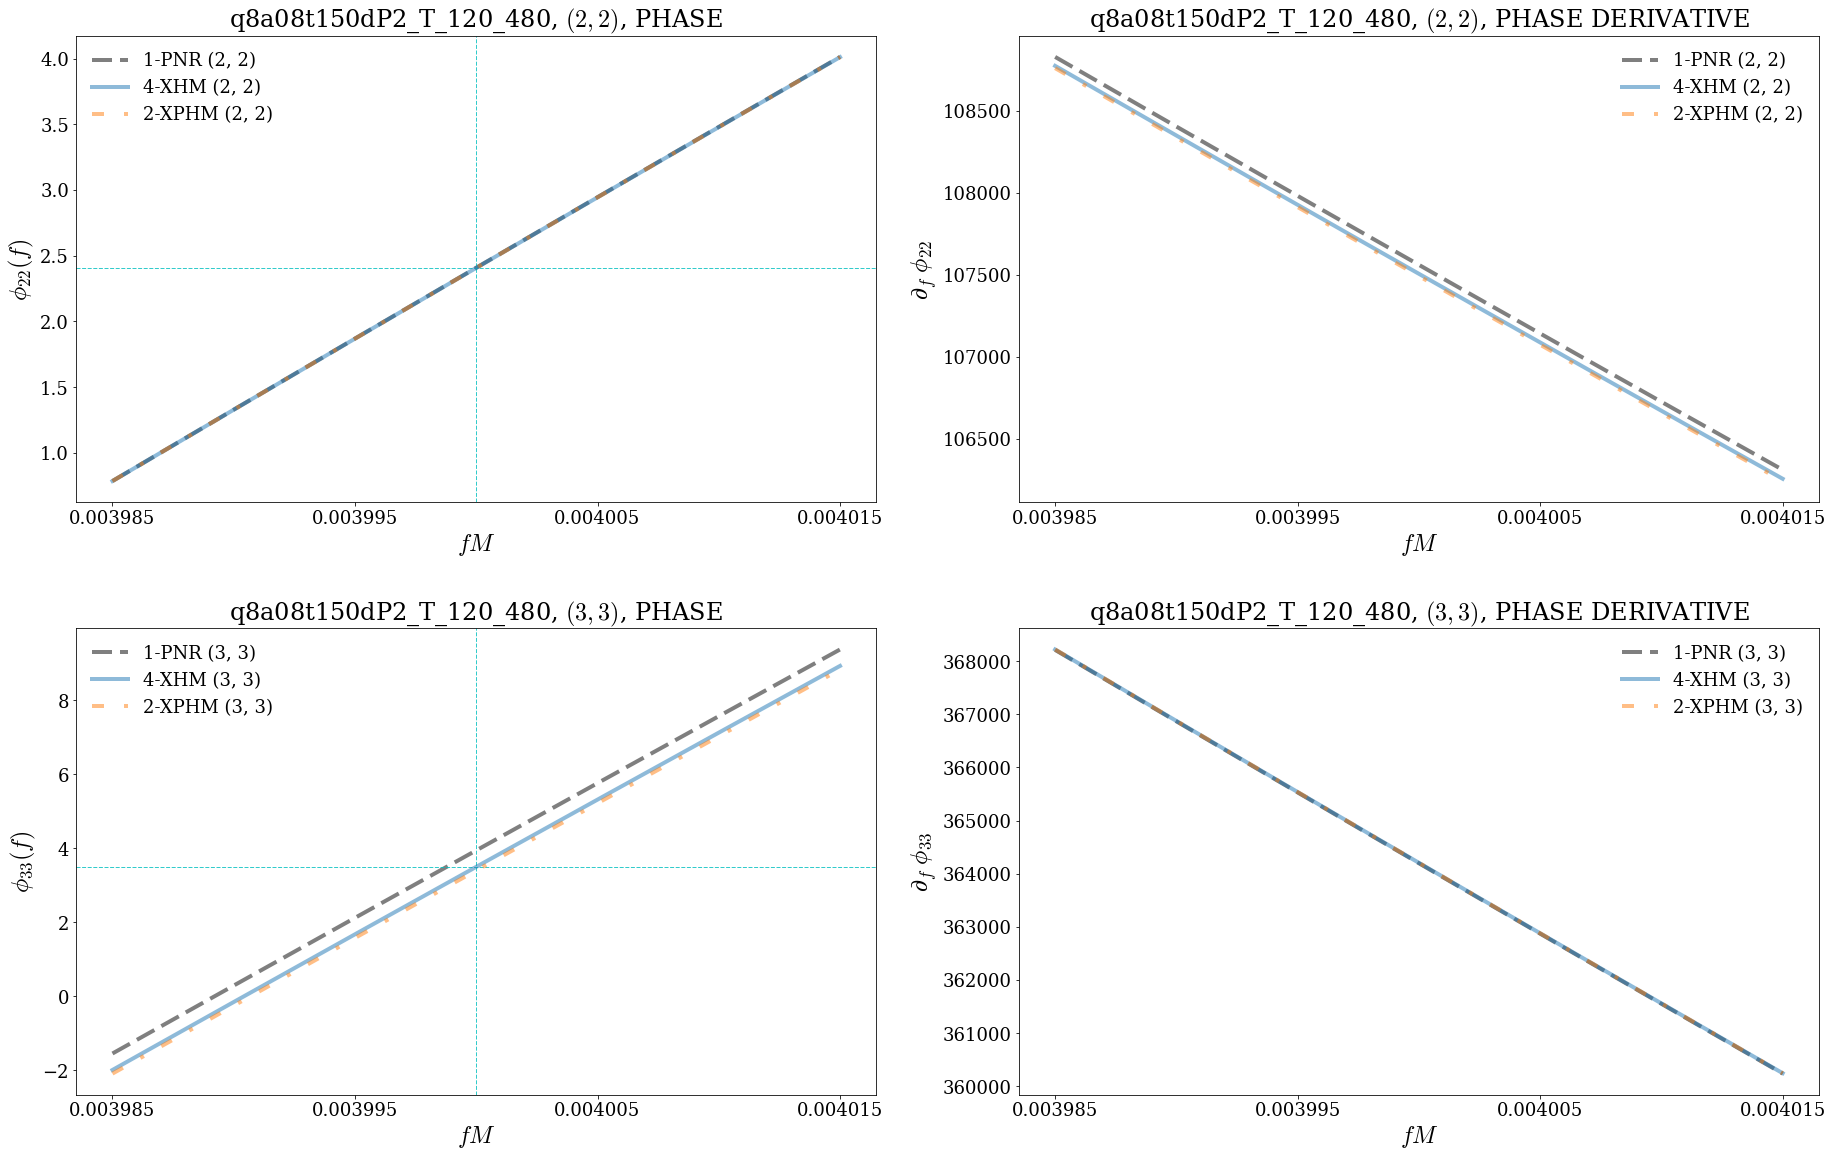

In [5]:

lmlist = [(2,2),(3,3)]

#
fig,ax = subplots(2,2,figsize=4*figaspect(0.618))
lw = 4
opts = ['1-pnr','4-xhm','2-xphm']
cs_list = ['k','tab:blue','tab:orange']
ls_list = ['--','-','-.']

cs  = { opts[k]:cs_list[k] for k in range(len(opts)) }
ls = { opts[k]:ls_list[k] for k in range(len(opts)) }

#
ax = ax.flatten()

for opt in opts:
    
    #
    f_inspiral_align = 0.004
    eps = 0.000015
    alert(opt,header=True)
    ff = linspace(f_inspiral_align-eps,f_inspiral_align+eps,int(1e3))
    phenom_moments_dict = xcp.get_phenomxphm_coprecessing_multipoles( ff,
                                                                      lmlist, 
                                                                      m1, 
                                                                      m2, 
                                                                      chi1_vec, 
                                                                      chi2_vec, 
                                                                      output_phase_from_lal=not True,
                                                                      option_shorthand=opt,
                                                                      force_xhm_phase_alignment=False ) 

    #
    for k in lmlist:
        
        #
        ll,mm = k
        
        #
        h = phenom_moments_dict[k]
        
        #
        #amp = abs(h)
        phi = unwrap(angle(h))#h-h[0]+mod(h[0],2*pi)
        dphi_raw = spline_diff( ff, phi )
        dphi = dphi_raw
        
        #
        if ll==2:
            kk=0
        else:
            kk=2
        
        #
        if k==(2,2):
            alert( 'phi = '+str(spline(ff,phi)(f_inspiral_align) ))
            alert( 'dphi = '+str(spline(ff,dphi)(f_inspiral_align)) )
            
        if opt=='4-xhm' :
            sca( ax[kk] )
            axhline( spline(ff,phi)(f_inspiral_align), ls='--', color='c' )
            axvline( f_inspiral_align, ls='--', color='c' )
        
        #
        sca( ax[kk] )
        plot( ff, phi, lw=lw, label=opt.upper()+' %s'%str(k), c = cs[opt], ls=ls[opt],alpha=0.5 )
        #xscale('log')
        ylabel(r'$\phi_{%i%i}(f)$'%(ll,mm))
        title(a.simname+', $(%i,%i)$, PHASE'%(ll,mm))
        
        #
        sca( ax[kk+1] )
        plot( ff, dphi, lw=lw, label=opt.upper()+' %s'%str(k), c = cs[opt], ls=ls[opt],alpha=0.5 )
        title(a.simname+', $(%i,%i)$, PHASE DERIVATIVE'%(ll,mm))
        ylabel(r'$\partial_f \; \phi_{%i%i}$'%(ll,mm))
    

#
tight_layout(h_pad=4)
for ax_ in ax:
    sca(ax_)
    xlabel('$fM$')
    legend()
    ax_.set_xticks( linspace(ff[0],ff[-1],4) )
    
#
# print('->.'*20)
# print('>> ',magenta('No alignment imposed'))
# print('-<.'*20)

#
alert('saving figure ... ',end='')
savefig('/Users/book/KOALA/PhenomXCP/gallery/9_force_phase_alignment/a_phase_comparison_%s.png'%a.simname,pad_inches=0,bbox_inches='tight')
print(blue('Done')+'.')

## Comments
* In early inspiral, XPHM and PNR should agree with XHM; however, this only appears to be the case for the $(2,2)$ phase
* With the exception of the $(2,2)$ phase, phase derivatives AND phase values differ
* The points above hold regardless of whether time-shift tuning, via `NU0`, is on of off
* In PhenomXHM, ***"the tail wags the dog"***, meaning that the inspiral values are determined by the intermediate-merger-ringdown morphology via continuity. And the merger-ringdown morphology of `XPHM` changes due to its modified ringdown frequency.

## Action Items
For $(2,2)$
* Add a global time-shift to `1-PNR` so that inspiral phase derivative matches `XHM` 


## 2. Force alignment of PNR-XCP phases and phase derivatives with XHM
* We now use `force_xhm_phase_alignment=True` in `xcp.get_phenomxphm_coprecessing_multipoles` which sets the appropriate flag in the `LALDict`


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> 1-pnr
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> phi = 3.496924408963149
(notebook)>> dphi = 364203.7617569541

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> 4-xhm
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> phi = 3.4969244089631233
(notebook)>> dphi = 364203.76175764715

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> 2-xphm
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> phi = 3.398588718167146
(notebook)>> dphi = 364204.0244158068
(notebook)>> saving figure ... Done.


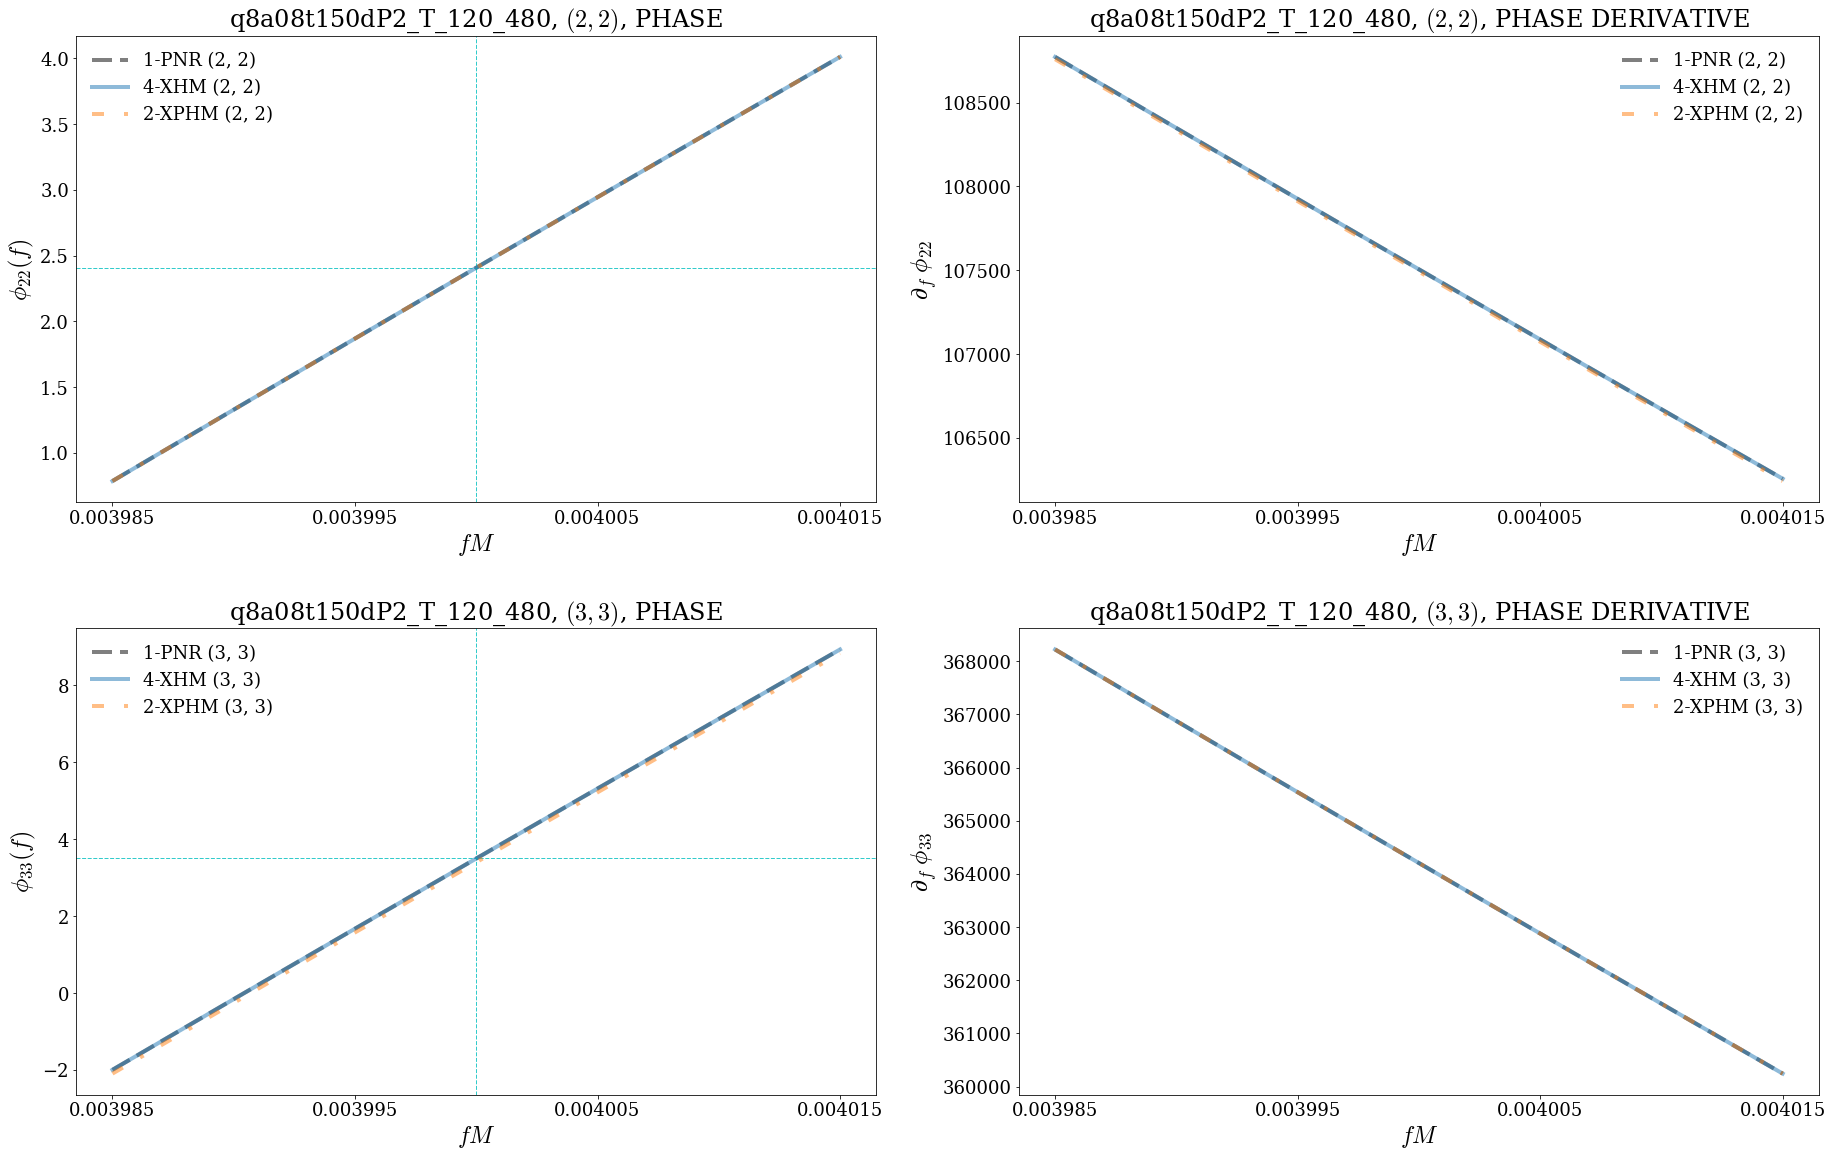

In [6]:

lmlist = [(2,2),(3,3)]

#
fig,ax = subplots(2,2,figsize=4*figaspect(0.618))
lw = 4
opts = ['1-pnr','4-xhm','2-xphm']
cs_list = ['k','tab:blue','tab:orange']
ls_list = ['--','-','-.']

cs  = { opts[k]:cs_list[k] for k in range(len(opts)) }
ls = { opts[k]:ls_list[k] for k in range(len(opts)) }

#
ax = ax.flatten()

for opt in opts:
    
    #
    f_inspiral_align = 0.004
    eps = 0.000015
    alert(opt,header=True)
    ff = linspace(f_inspiral_align-eps,f_inspiral_align+eps,int(1e3))
    #ff = linspace(0.035,0.125*1.5,1e4)
    phenom_moments_dict = xcp.get_phenomxphm_coprecessing_multipoles( ff,
                                                                      lmlist, 
                                                                      m1, 
                                                                      m2, 
                                                                      chi1_vec, 
                                                                      chi2_vec, 
                                                                      output_phase_from_lal=not True,
                                                                      option_shorthand=opt,
                                                                      force_xhm_phase_alignment=True ) 

    #
    for k in lmlist:
        
        #
        ll,mm = k
        
        #
        h = phenom_moments_dict[k]
        
        #
        #amp = abs(h)
        phi = unwrap(angle(h))#h-h[0]+mod(h[0],2*pi)
        dphi_raw = spline_diff( ff, phi )
        dphi = dphi_raw
        
        #
        if ll==2:
            kk=0
        else:
            kk=2
        
        #
        if k==(3,3):
            alert( 'phi = '+str( mod(spline(ff,phi)(f_inspiral_align),2*pi) ))
            alert( 'dphi = '+str(spline(ff,dphi)(f_inspiral_align)) )
            
        if opt=='4-xhm' :
            sca( ax[kk] )
            axhline( spline(ff,phi)(f_inspiral_align), ls='--', color='c' )
            axvline( f_inspiral_align, ls='--', color='c' )
        
        #
        sca( ax[kk] )
        plot( ff, phi, lw=lw, label=opt.upper()+' %s'%str(k), c = cs[opt], ls=ls[opt],alpha=0.5 )
        #xscale('log')
        ylabel(r'$\phi_{%i%i}(f)$'%(ll,mm))
        title(a.simname+', $(%i,%i)$, PHASE'%(ll,mm))
        
        #
        sca( ax[kk+1] )
        plot( ff, dphi, lw=lw, label=opt.upper()+' %s'%str(k), c = cs[opt], ls=ls[opt],alpha=0.5 )
        title(a.simname+', $(%i,%i)$, PHASE DERIVATIVE'%(ll,mm))
        ylabel(r'$\partial_f \; \phi_{%i%i}$'%(ll,mm))
    

#
tight_layout(h_pad=4)
for ax_ in ax:
    sca(ax_)
    xlabel('$fM$')
    legend()
    ax_.set_xticks( linspace(ff[0],ff[-1],4) )
    
#
# print('->.'*20)
# print('>> ',magenta('No alignment imposed'))
# print('-<.'*20)

#
alert('saving figure ... ',end='')
savefig('/Users/book/KOALA/PhenomXCP/gallery/9_force_phase_alignment/b_phase_comparison_%s.png'%a.simname,pad_inches=0,bbox_inches='tight')
print(blue('Done')+'.')